In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import statsmodels.api as sm

sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')
sns.set_style('white')
#plt.rcParams["figure.dpi"] = 600
from sklearn.model_selection import train_test_split

In [3]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import os
os.listdir()


['.ipynb_checkpoints',
 'cc1a3 MPN R analysis.ipynb',
 'cc1a3_dilution2extinction.ipynb',
 'dilution2extinction']

In [5]:
dpath = 'dilution2extinction'
flist = [f for f in os.listdir('dilution2extinction') if f.endswith('.csv')]
         
flist

['a_d0.csv',
 'a_d1.csv',
 'a_d4.csv',
 'c_d0.csv',
 'c_d1.csv',
 'c_d4.csv',
 'p_d0.csv',
 'p_d1.csv',
 'p_d4.csv']

In [18]:
def _read_csv(fname):
    fpath = os.path.join(dpath, fname)
    print(fpath)
    df = pd.read_csv(fpath, skiprows=11, nrows=96, encoding_errors='replace')
    df['fname'] = fname
    df['plate'] = fname.split('.')[0].rsplit('_', 1)[0]
    
    df['row'] = df['Well'].str.slice(start=0, stop=1)
    df['column'] = pd.to_numeric(df['Well'].str.slice(start=1, ))
    s1, dstr  = fname.split('.')[0].split('_')
    df['day'] = pd.to_numeric(dstr[1:])
    df.loc[df['row'].isin(['A', 'H']), 'Sample'] = 'CTRL'
    df.loc[df['row'].isin(['B', 'C', ]), 'Sample'] = s1.upper() + '0A'
    df.loc[df['row'].isin(['D', 'E', ]), 'Sample'] = s1.upper() + '0B'
    df.loc[df['row'].isin(['F', 'G', ]), 'Sample'] = s1.upper() + '0C'
    #df.loc[df['row'].isin(['E', 'F', 'G']), 'Sample'] = s2
    df = df.drop('Unnamed: 3', axis=1).rename(columns={'MeasA:Result': 'Measure'})    
    return df

df = pd.concat([_read_csv(f) for f in flist])



dilution2extinction\a_d0.csv
dilution2extinction\a_d1.csv
dilution2extinction\a_d4.csv
dilution2extinction\c_d0.csv
dilution2extinction\c_d1.csv
dilution2extinction\c_d4.csv
dilution2extinction\p_d0.csv
dilution2extinction\p_d1.csv
dilution2extinction\p_d4.csv


In [19]:
df['plate_Well'] = df['plate'] + df['Well']
d0_df = df.loc[df.day ==0, ['plate_Well', 'Measure']]
d0_df.index = d0_df['plate_Well']

df['d0_Measure'] = df['plate_Well'].map(d0_df['Measure'])

In [20]:
df['Measure_diff'] = df['Measure'] - df['d0_Measure']

In [21]:
df['isOK'] = True
#df.loc[df.plate.isin(['11b_11c']) & df.row.isin(['G','H']),'isOK'] = False

In [22]:
df['cummin_Measure_diff'] = df.groupby(['plate', 'row', 'day'])['Measure_diff'].transform('cummin')

In [23]:
df['Measure_diff_fixed'] = df['Measure_diff']
mask = df.cummin_Measure_diff.lt(0.15) & df.Measure_diff.ge(0.15)
df.loc[mask, 'Measure_diff_fixed'] = df.loc[mask, 'cummin_Measure_diff']

In [24]:
df['Positive_growth'] = False
df.loc[df['Measure_diff_fixed'].ge(0.15), 'Positive_growth'] = True

In [25]:
df.head()

,Well,Sample,Measure,fname,plate,row,column,day,plate_Well,d0_Measure,Measure_diff,isOK,cummin_Measure_diff,Measure_diff_fixed,Positive_growth
0,A01,CTRL,0.144,a_d0.csv,a,A,1,0,aA01,0.144,0.0,True,0.0,0.0,False
1,A02,CTRL,0.145,a_d0.csv,a,A,2,0,aA02,0.145,0.0,True,0.0,0.0,False
2,A03,CTRL,0.163,a_d0.csv,a,A,3,0,aA03,0.163,0.0,True,0.0,0.0,False
3,A04,CTRL,0.148,a_d0.csv,a,A,4,0,aA04,0.148,0.0,True,0.0,0.0,False
4,A05,CTRL,0.148,a_d0.csv,a,A,5,0,aA05,0.148,0.0,True,0.0,0.0,False


In [26]:
df.columns

Index(['Well', 'Sample', 'Measure', 'fname', 'plate', 'row', 'column', 'day',
       'plate_Well', 'd0_Measure', 'Measure_diff', 'isOK',
       'cummin_Measure_diff', 'Measure_diff_fixed', 'Positive_growth'],
      dtype='object')

In [27]:
df['Measure_diff'].describe()

count    864.000000
mean       0.036981
std        0.143214
min       -0.537000
25%       -0.020250
50%        0.000000
75%        0.001000
max        0.788000
Name: Measure_diff, dtype: float64

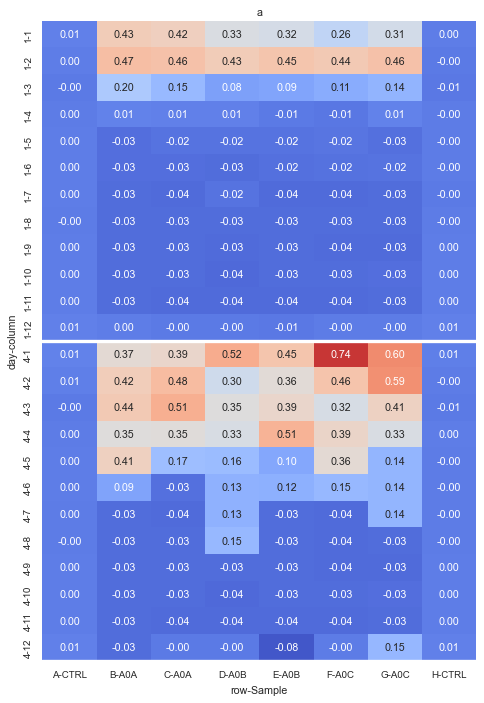

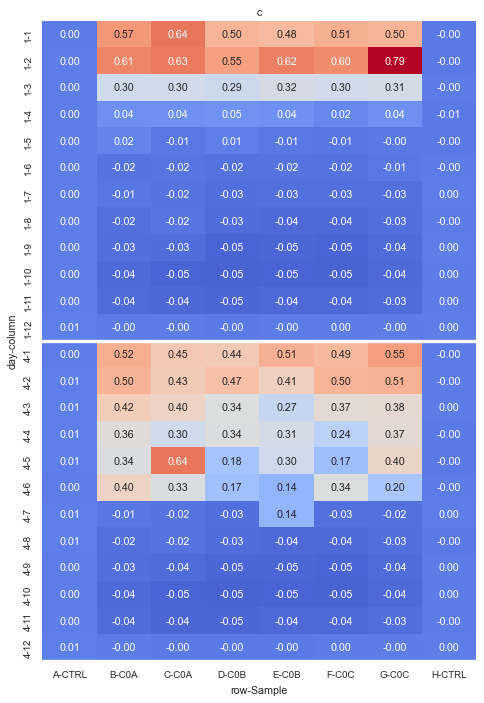

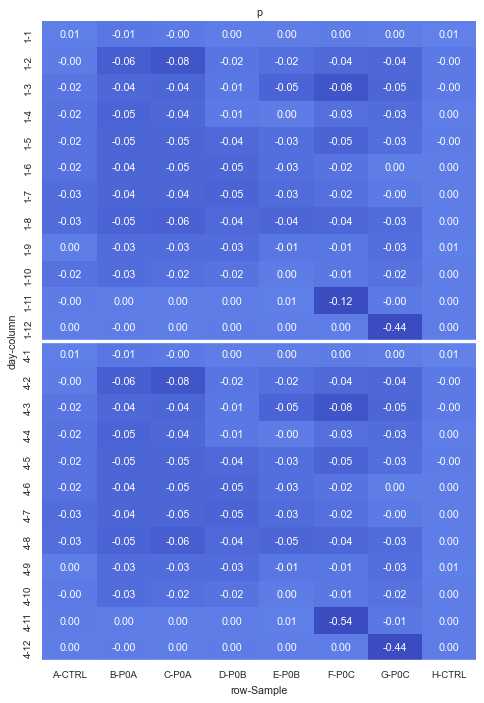

In [29]:
sns.set_context('paper')
#fig, ax = plt.subplots(figsize=(20, 6))
for plate in df.plate.unique():
    plt.figure(figsize=(7, 10))
    pdf = df.loc[df.plate.isin([plate]) & (df.day.ge(1)) & df.isOK 
                ].pivot_table(values='Measure_diff_fixed', columns=['row', 'Sample'], index=['day','column'],
                                                )
    sns.heatmap(pdf, annot=True, fmt=".2f", cmap='coolwarm', cbar=False, vmin=-0.1, vmax=df['Measure_diff'].max(),
               #annot_kws={'rotation': 90}
               )
    plt.axhline(12,c='w', lw=3)
    plt.axhline(12*2,c='w', lw=3)
    plt.axhline(12*3,c='w', lw=3)
    plt.axhline(12*4,c='w', lw=3)
    plt.title(plate)

    plt.show()




In [30]:
df.head()

,Well,Sample,Measure,fname,plate,row,column,day,plate_Well,d0_Measure,Measure_diff,isOK,cummin_Measure_diff,Measure_diff_fixed,Positive_growth
0,A01,CTRL,0.144,a_d0.csv,a,A,1,0,aA01,0.144,0.0,True,0.0,0.0,False
1,A02,CTRL,0.145,a_d0.csv,a,A,2,0,aA02,0.145,0.0,True,0.0,0.0,False
2,A03,CTRL,0.163,a_d0.csv,a,A,3,0,aA03,0.163,0.0,True,0.0,0.0,False
3,A04,CTRL,0.148,a_d0.csv,a,A,4,0,aA04,0.148,0.0,True,0.0,0.0,False
4,A05,CTRL,0.148,a_d0.csv,a,A,5,0,aA05,0.148,0.0,True,0.0,0.0,False


In [31]:
#df_pos = df.loc[df.day.isin([1])].groupby(['Sample', 'column']).agg({'Measure_diff':'mean', 'Positive_growth': 'sum'}).reset_index()
df_pos = df.loc[
    df.day.isin([1,2,3,4,7]) & df.isOK
].groupby(['Sample', 'day', 'column']).agg({'Measure_diff_fixed':'mean', 'Positive_growth': 'sum', 'row': 'count'}).reset_index()

In [32]:
df_pos.rename(columns={'row': 'n'}, inplace=True)

In [33]:
df_pos

,Sample,day,column,Measure_diff_fixed,Positive_growth,n
0,A0A,1,1,0.4225,2,2
1,A0A,1,2,0.4685,2,2
2,A0A,1,3,0.1780,2,2
3,A0A,1,4,0.0095,0,2
4,A0A,1,5,-0.0235,0,2
...,...,...,...,...,...,...
235,P0C,4,8,-0.0385,0,2
236,P0C,4,9,-0.0200,0,2
237,P0C,4,10,-0.0145,0,2
238,P0C,4,11,-0.2730,0,2


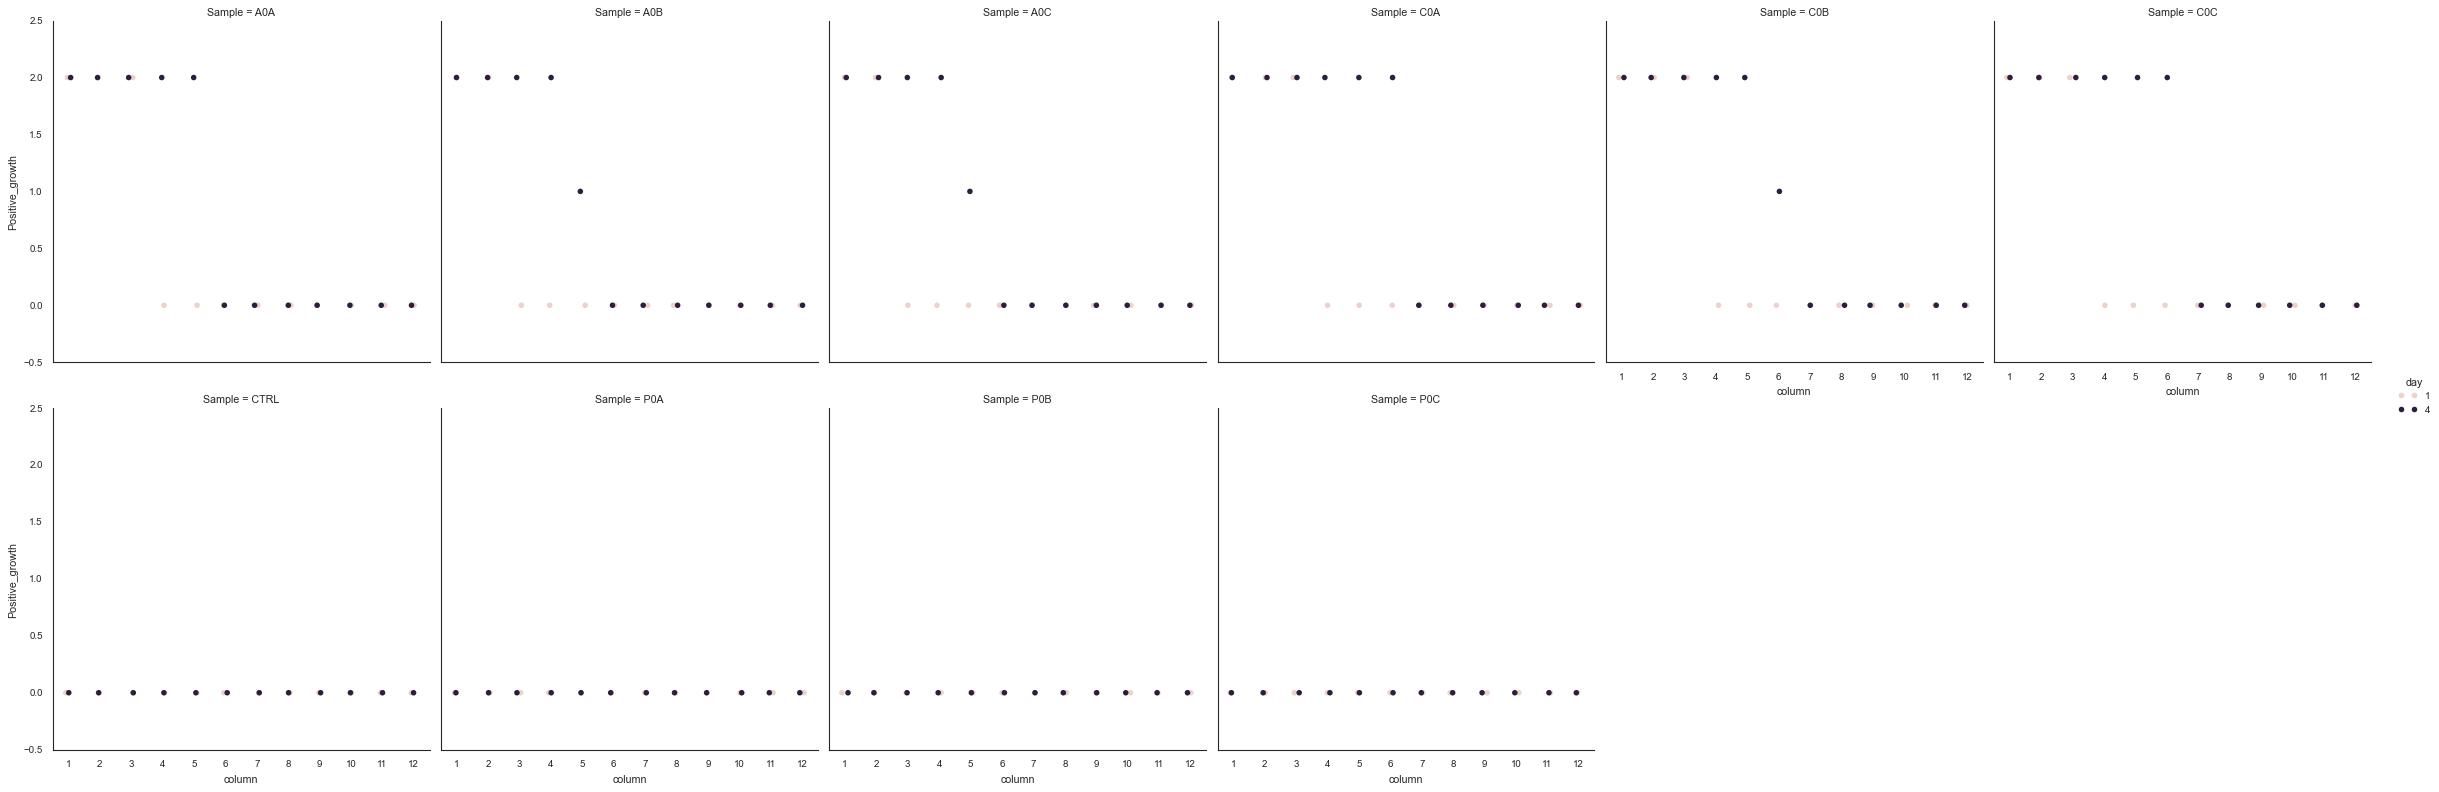

In [34]:
sns.catplot(
    data=df_pos,
    x='column', y='Positive_growth', 
    col='Sample', col_wrap=6, hue='day'
)

In [40]:
os.makedirs('data', exist_ok=True)
df_pos.loc[df_pos.day.isin([4])].to_csv('data/MPN_positive_growth.csv', index=False)

In [30]:
df_pos2 = df.loc[df.day.isin([2])].groupby(['Sample', 'column']).agg({'Measure_diff':'mean', 'Positive_growth': 'sum'}).reset_index()

In [31]:
df_pos2.to_csv('data/MPN_positive_growth_day2.csv', index=False)
